In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def get_linear_data() -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    np.random.seed(42)
    params = np.array([2.0, -3.0])
    line = np.poly1d(params)
    x = np.linspace(-10, 10, 100)
    y = line(x) + np.random.normal(0.0, 2.0, x.size)
    return x, y, params


def fit_line(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return np.polyfit(x, y, 1)

Let us get initial (noisy) linear data:
$$
y = 2x - 3 + \varepsilon,
$$

where, say, $\varepsilon \sim \mathcal{N}(0, 2)$.

In [3]:
x, y, params = get_linear_data()

The best fit is somewhat close to the original line.

In [4]:
best_line = fit_line(x, y)
best_line

array([ 2.01379327, -3.20769303])

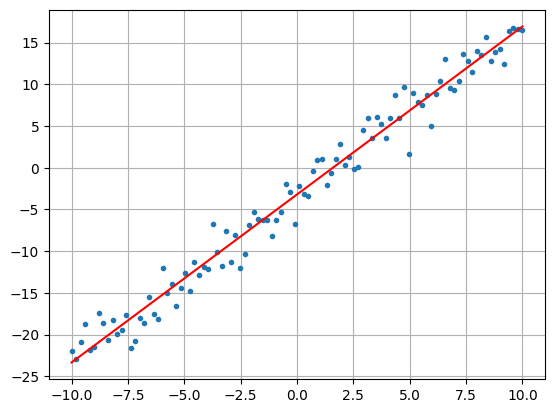

In [5]:
plt.plot(x, y, '.')
plt.plot(x, np.polyval(best_line, x), color='red')
plt.grid()
plt.show()

Now we simulate many nudges with different deviations and look at how parameter deviations change.

In [6]:
def simulate_fits_nudge_points(
    sigma: float, x: np.ndarray, y: np.ndarray
) -> tuple[list[float], list[float]]:
    N_TOTAL = 5_000

    param_history = []

    for _ in range(N_TOTAL):
        y_new = y + np.random.normal(0.0, sigma, x.size)
        param_history.append(fit_line(x, y_new))

    slopes, intercepts = zip(*param_history)

    return list(slopes), list(intercepts)


In [7]:
slopes, intercepts = simulate_fits_nudge_points(1.0, x, y)

Nudging the original y-values by the values from the standard normal distribution, we get the following noisy parameter estimates:

In [8]:
slopes_mean, slopes_std = norm.fit(slopes)
intercepts_mean, intercepts_std = norm.fit(intercepts)
print(f"Mean slope: {slopes_mean:.3f} ± {slopes_std:.3f}")
print(f"Mean intercept: {intercepts_mean:.3f} ± {intercepts_std:.3f}")

Mean slope: 2.014 ± 0.017
Mean intercept: -3.209 ± 0.102


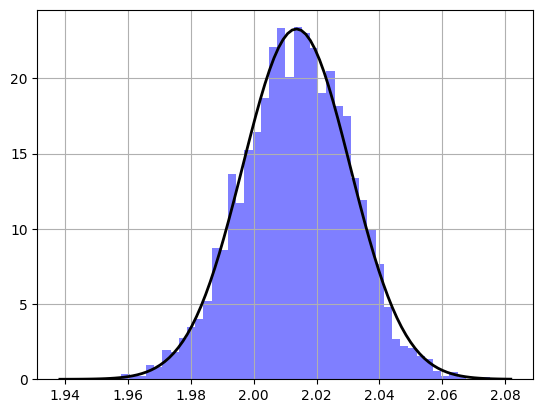

In [9]:
plt.hist(slopes, bins=50, color='blue', alpha=0.5, density=True)
xmin, xmax = plt.xlim()
x_hist = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_hist, slopes_mean, slopes_std)
plt.plot(x_hist, p, 'k', linewidth=2)
plt.grid()
plt.show()

Now, what happens if we vary the noise level?

In [10]:
SIGMAS = np.linspace(0.1, 2.0, 1_000)

In [11]:
slope_mean_std_vals = []
intercept_mean_std_vals = []

for sigma_ in SIGMAS:
    slopes, intercepts = simulate_fits_nudge_points(sigma_, x, y)
    slopes_mean, slopes_std = norm.fit(slopes)
    intercepts_mean, intercepts_std = norm.fit(intercepts)
    slope_mean_std_vals.append((slopes_mean, slopes_std))
    intercept_mean_std_vals.append((intercepts_mean, intercepts_std))

In [12]:
slope_means = [el[0] for el in slope_mean_std_vals]
slope_stds = [el[1] for el in slope_mean_std_vals]
intercept_means = [el[0] for el in intercept_mean_std_vals]
intercept_stds = [el[1] for el in intercept_mean_std_vals]

Clearly, the estimations for the means of the parameters are not affected by the noise level (except that they get more noisy themselves):

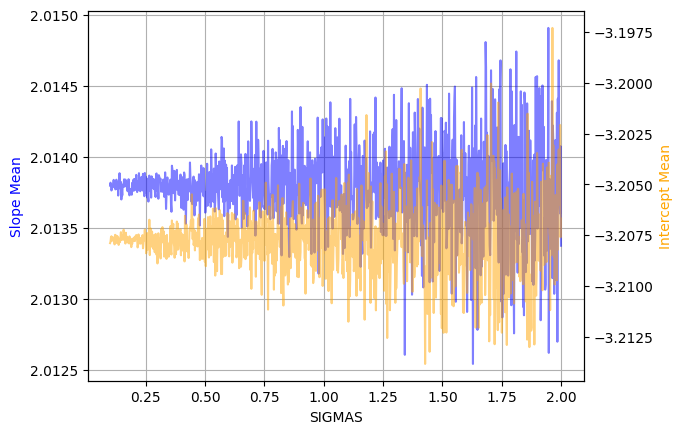

In [13]:
fig, ax1 = plt.subplots()

ax1.plot(SIGMAS, slope_means, label="slope mean", alpha=0.5, color="blue")
ax1.set_ylabel("Slope Mean", color="blue")
ax1.tick_params(axis="y")

ax2 = ax1.twinx()
ax2.plot(SIGMAS, intercept_means, label="intercept mean", alpha=0.5, color="orange")
ax2.set_ylabel("Intercept Mean", color="orange")
ax2.tick_params(axis="y")

ax1.set_xlabel("SIGMAS")
ax1.grid()
plt.show()


However, the standard deviations of the parameter estimates increase with the noise level, and linearly so:

Slope Fit:  
0.01718 x - 2.298e-05
Intercept Fit:  
0.1 x - 2.798e-05


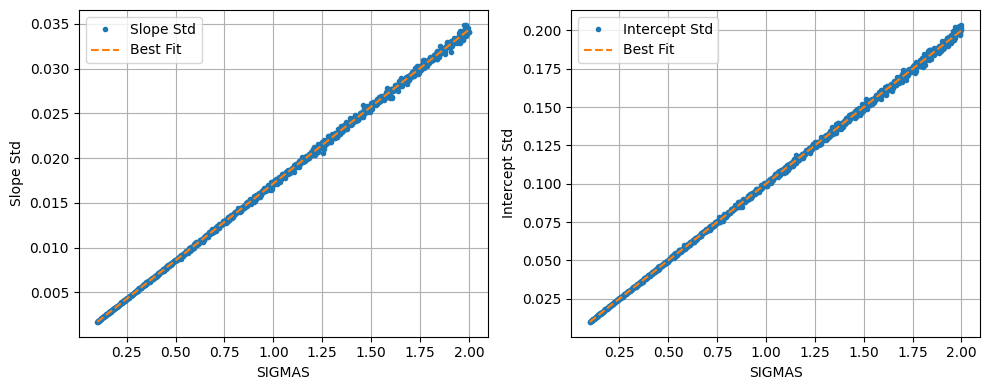

In [15]:
slope_fit = np.polyfit(SIGMAS, slope_stds, 1)
slope_poly = np.poly1d(slope_fit)

intercept_fit = np.polyfit(SIGMAS, intercept_stds, 1)
intercept_poly = np.poly1d(intercept_fit)


print(f"Slope Fit: {slope_poly}")
print(f"Intercept Fit: {intercept_poly}")


SIGMAS_fine = np.linspace(min(SIGMAS), max(SIGMAS), 100)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(SIGMAS, slope_stds, ".", label="Slope Std")
ax1.plot(SIGMAS_fine, slope_poly(SIGMAS_fine), "--", label="Best Fit")
ax1.set_xlabel("SIGMAS")
ax1.set_ylabel("Slope Std")
ax1.grid()
ax1.legend()


ax2.plot(SIGMAS, intercept_stds, ".", label="Intercept Std")
ax2.plot(SIGMAS_fine, intercept_poly(SIGMAS_fine), "--", label="Best Fit")
ax2.set_xlabel("SIGMAS")
ax2.set_ylabel("Intercept Std")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()


Where does this linear dependence come from?